In [1]:
#Import dependencies
import pandas as pd
import requests
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime


In [2]:
df = pd.read_csv('PlusLiga.csv')
#To view all the columns
pd.set_option('display.max_columns', None)

In [3]:
#Change the data of when a game was played into a datetime datatype for parsing
input_format = "%d.%m.%Y, %H:%M"
df['Time'] = pd.to_datetime(df['Time'], format = input_format)
#Separate the day and the time into different columns
df['Date'] = df['Time'].dt.date
df['Time'] = df['Time'].dt.time
df['Date'] = pd.to_datetime(df['Date'])


In [4]:
#Here we prepare the nonlinear features as well as the target.
#Assign integer values to each date, 0 (Monday) to 6.
df['Weekdate'] = df['Date'].apply(lambda x: x.weekday())
#This is our target variable. Team 1 winning has a value of 1, losing is 0.
df['Team1Dub'] = df.apply(lambda row: 1 if row['Score1']
                          >= row['Score2'] else 0, axis = 1)
#Convert the time at which a game was played into integer values
df['Decimaltime'] = df['Time'].apply(lambda t: t.hour + t.minute/60)
#Assign unique integers as a 'label' of Team 1.
df['Team1ID'] = pd.factorize(df['Team1'])[0]

In [5]:
#Now let's look at the linear features
cols = ['ServeEff1', 'ServeEff2', 'PosPercent1', 'PosPercent2', 'KillPercent1',
        'KillPercent2',
        'EffPercent1', 'EffPercent2']
#Since these variables are all percentages, we remove the % sign to get ints
df[cols] = df[cols].applymap(lambda x: int(x.strip('%')))
#So that cols includes all linear features we want to analyze:
cols+=['Points1', 'Points2', 'Score1', 'Score2']

In [6]:
#Create a new list of columns, newcols, representing all the
#features in cols but as rolling averages.
newcols=[f"rolling{c}" for c in cols]
def rollavg(group, cols, newcols):
    group = group.sort_values(by='Date')
    #Closed = left so that we don't include a current game's feature variables.
    #Since we do not know a current game's serve efficiency and so on
    # before a game begins, using these as part of the rolling average
    #would give us unrealistic predictors
    rollingstats = group[cols].rolling(3, closed='left').mean()
    group[newcols] = rollingstats
    #This creates missing data because sometimes we take the avg of the last
    #3 games when there are only, say, 1 previous game. So we drop rows.
    group = group.dropna(subset=newcols)
    return group

In [7]:
#Group by teams and apply the rollavg function on all teams to yield the
#newcols (rolling average features)
dfr = df.groupby('Team1ID').apply(lambda x: rollavg(x, cols, newcols))
dfr = dfr.droplevel('Team1ID')
dfr = dfr.reset_index(drop=True)

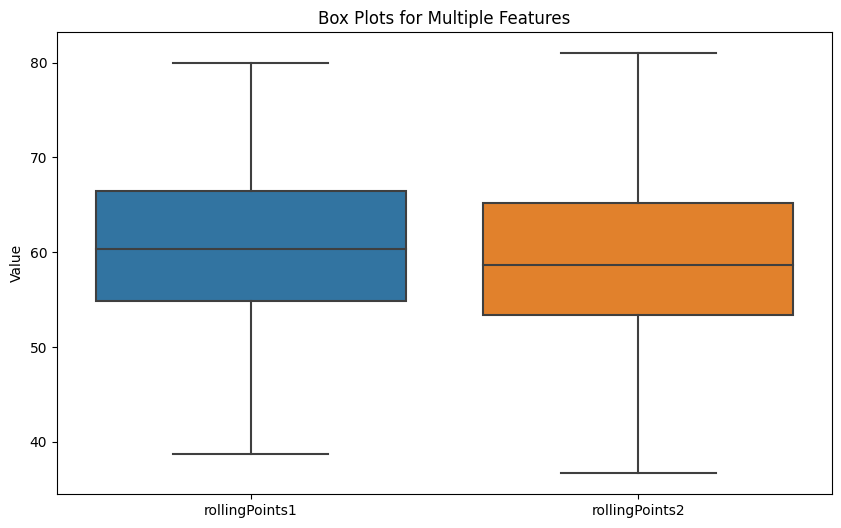

In [8]:
#Create box plots for two features. This is because I want to ensure there are
#not too many outliers so that I can then apply minmax scaling. The other cols
#don't need to be graphed because they are all min 0 max 100 (being percentages)
bpeda = ['rollingPoints1', 'rollingPoints2']
plt.figure(figsize=(10, 6))
sns.boxplot(data=dfr[bpeda], orient='v')  # 'v' for vertical orientation
plt.title('Box Plots for Multiple Features')
plt.ylabel('Value')

# Show the plot
plt.show()

In [9]:
#Use minmax scaling on the columns
scaler = MinMaxScaler()
dfr[newcols] = scaler.fit_transform(dfr[newcols])
#Create the train and test set. The date is determined by how the polish league
#is split, with this year's "essential phase" being before april 7
#and this year's "playoff phase" being after april 7
train = dfr[dfr['Date'] < '2023-04-07']
test = dfr[dfr['Date'] >= '2023-04-07']
#Create a list of the nonlinear features we prepared earlier
predictors = ['Weekdate', 'Decimaltime', 'Team1ID']

In [10]:
#Set up our y test and train
y_train = train['Team1Dub']
y_test = test['Team1Dub']
#X_train/test_nonlin only uses the nonlinear predictors
X_train_nonlin = train[predictors]
X_test_nonlin = test[predictors]
#X_train/test uses only the linear predictors
X_train = train[newcols]
X_test = test[newcols]
#X_train_com uses both
combined = predictors + newcols
X_train_com = train[combined]
X_test_com = test[combined]

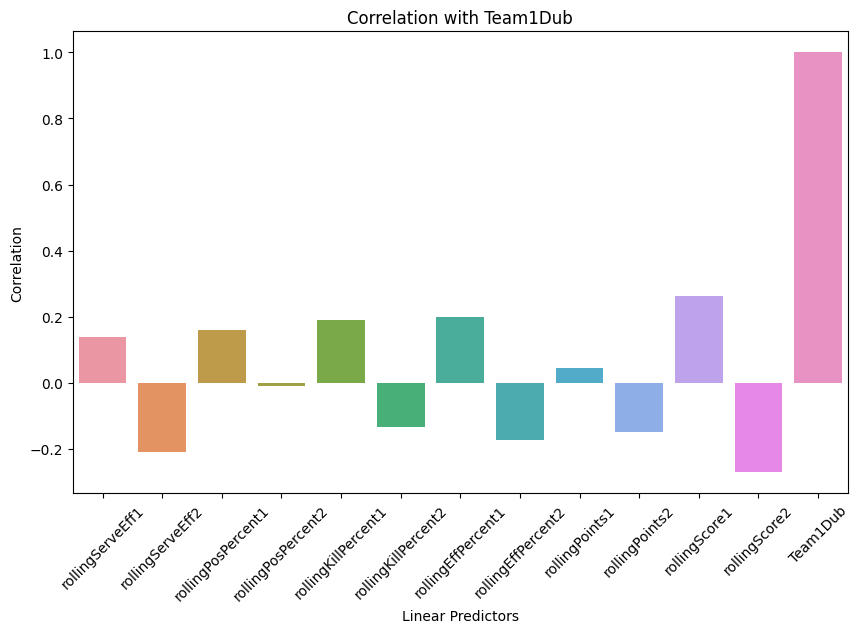

In [11]:
#To see each linear feature's correlation with our target variable w/ a barplot
correlation = dfr[newcols + ['Team1Dub']].corr()['Team1Dub']
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlation with Team1Dub')
plt.xlabel('Linear Predictors')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()


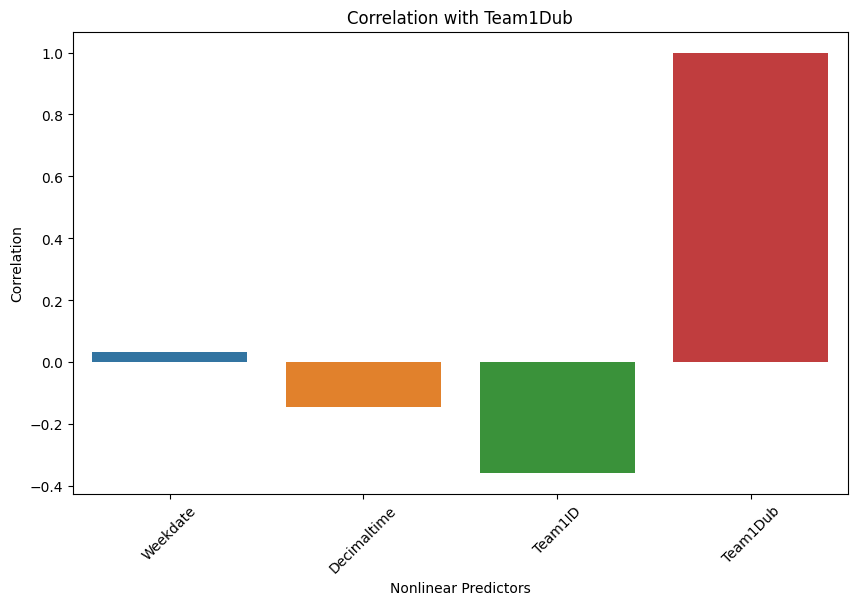

In [12]:
#To see each nonlinear feature's correlation with our target w/ a barplot
correlation = dfr[predictors + ['Team1Dub']].corr()['Team1Dub']
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlation with Team1Dub')
plt.xlabel('Nonlinear Predictors')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()
#We will probably include the nonlinear predictors because it's clear the Team 1
#name is relatively important

In [13]:
#Define a function for fitting and predicting
def trainpredict(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    f1, accuracy, precisionp = (f1_score(y_test, y_pred, pos_label=1),
                                sum(y_test == y_pred) / float(len(y_pred)),
                                precision_score(y_test, y_pred, pos_label=1))
#Gives us the f1 score, the accuracy, and the precision
    print(f1,'f1 and accuracy', accuracy,'and precision', precisionp)

In [14]:
#Create instances of our 5 classification algorithms we will be using
xgclf = XGBClassifier(random_state=1)
lrclf = LogisticRegression(random_state=1)
svclf = SVC(random_state = 1, kernel = 'rbf')
rfclf = RandomForestClassifier(n_estimators=50, min_samples_split=15,
                               random_state=1)
knnclf = KNeighborsClassifier(n_neighbors=5)
#Here, I trained the svc and lr algos on just the linear features
#while I trained the random forest, XGBoost, and KNN on the linear features,
#nonlinear features, and the combined features. This was because I figured the
#RF XG and KNN Algorithims were more versatile for working with nonlinear data
#Such as a game ID where a higher game ID doesn't necessarily mean better team
print("RF")
trainpredict(rfclf, X_train_com, y_train, X_test_com, y_test)
trainpredict(rfclf, X_train_nonlin, y_train, X_test_nonlin, y_test)
trainpredict(rfclf, X_train, y_train, X_test, y_test)
print("XG")
trainpredict(xgclf, X_train_com, y_train, X_test_com, y_test)
trainpredict(xgclf, X_train_nonlin, y_train, X_test_nonlin, y_test)
trainpredict(xgclf, X_train, y_train, X_test, y_test)
print("LR and SVC")
trainpredict(lrclf, X_train, y_train, X_test, y_test)
trainpredict(svclf, X_train, y_train, X_test, y_test)
print("KNN")
trainpredict(knnclf, X_train_com, y_train, X_test_com, y_test)
trainpredict(knnclf, X_train_nonlin, y_train, X_test_nonlin, y_test)
trainpredict(knnclf, X_train, y_train, X_test, y_test)

RF
0.6792452830188679 f1 and accuracy 0.5526315789473685 and precision 0.6
0.7142857142857143 f1 and accuracy 0.5789473684210527 and precision 0.6060606060606061
0.5531914893617021 f1 and accuracy 0.4473684210526316 and precision 0.5416666666666666
XG
0.5777777777777778 f1 and accuracy 0.5 and precision 0.5909090909090909
0.6923076923076923 f1 and accuracy 0.5789473684210527 and precision 0.6206896551724138
0.5714285714285715 f1 and accuracy 0.5263157894736842 and precision 0.631578947368421
LR and SVC
0.6250000000000001 f1 and accuracy 0.5263157894736842 and precision 0.6
0.6415094339622641 f1 and accuracy 0.5 and precision 0.5666666666666667
KNN
0.7142857142857143 f1 and accuracy 0.5789473684210527 and precision 0.6060606060606061
0.7142857142857143 f1 and accuracy 0.5789473684210527 and precision 0.6060606060606061
0.5416666666666667 f1 and accuracy 0.42105263157894735 and precision 0.52


In [15]:
#I ended up going with XGBoost despite the above data because after tuning it
#gave the best results for f1 score, trained on the combined dataset
parameters = {
                'learning_rate' : [0.01],
                'n_estimators' : [300],
                'max_depth': [5],
                'min_child_weight': [5],
                'gamma':[0.4],

}
finalclf = XGBClassifier(random_state=1)
#Used f1 score as the metric for deciding how to optimize parameters
grid_obj = GridSearchCV(finalclf,
                        scoring='f1',
                        param_grid=parameters,
                        cv=5, n_jobs=-1)
grid_obj.fit(X_train_com, y_train)
best_params = grid_obj.best_params_
print(best_params)
bestest = grid_obj.best_estimator_
trainpredict(bestest, X_train_com, y_train, X_test_com, y_test)
#So now we have our final model "bestest" that we can use for predicting the
#game winners

{'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}
0.7272727272727273 f1 and accuracy 0.6052631578947368 and precision 0.625
